In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sqlalchemy import create_engine
from sklearn import linear_model
import seaborn as sns
from scipy.stats.mstats import winsorize

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [2]:
house_prices = house_prices[house_prices.grlivarea != 5642]

In [3]:
Y = house_prices['saleprice']
X = house_prices[['grlivarea', 'overallqual']]

lrm = linear_model.LinearRegression()
lrm.fit(X, Y)
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [   60.81190923 32290.24433252]

Intercept: 
 -107912.75409850894


## Assumption one: linearity of the model in its coefficients

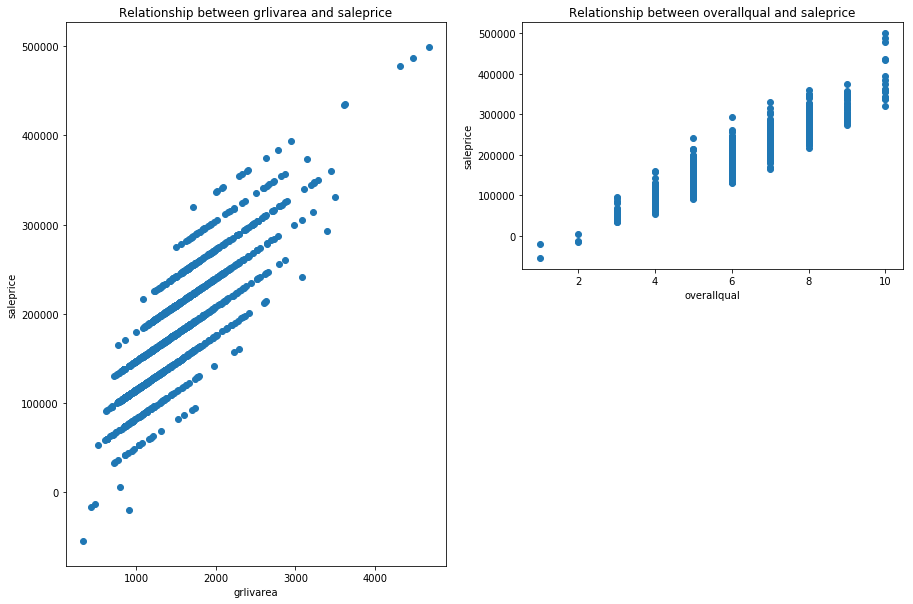

In [4]:
lrm_model = linear_model.LinearRegression()
lrm_model.fit(house_prices[['grlivarea', 'overallqual']], house_prices['saleprice'])
predictions = lrm_model.predict(house_prices[['grlivarea', 'overallqual']])

plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.scatter(house_prices['grlivarea'], predictions)
plt.xlabel("grlivarea")
plt.ylabel("saleprice")
plt.title('Relationship between grlivarea and saleprice')

plt.subplot(2,2,2)
plt.scatter(house_prices['overallqual'], predictions)
plt.xlabel("overallqual")
plt.ylabel("saleprice")
plt.title('Relationship between overallqual and saleprice')
plt.show()

There is an issuie with these plots. it do esnot look linerar

## Assumption two: the error term should be zero on average

In [5]:
predictions = lrm.predict(house_prices[['grlivarea', 'overallqual']])
errors = Y - predictions

print("Mean of the errors in the temperature model is: {}".format(np.mean(errors)))

Mean of the errors in the temperature model is: 5.126582883742674e-12


Since, we include the constant term in the model, the average of the model's error is effectively zero.

## Assumption three: homoscedasticity

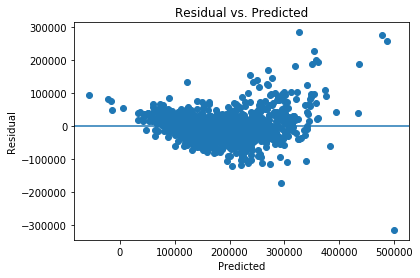

In [6]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [7]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 348.465 and p value is 9.15e-78
Levene test statistic value is 375.716 and p value is 7.91e-79


The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic.

## Assumption four: low multicollinearity

In [8]:
house_prices[['grlivarea', 'overallqual']].corr()

,grlivarea,overallqual
grlivarea,1.000,0.592
overallqual,0.592,1.000


Multicollinearity is relatively high in this model. Multicollinearity could exist

## Assumption five: error terms should be uncorrelated with one another

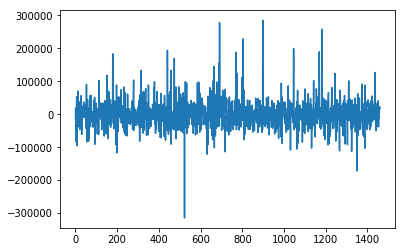

In [9]:
plt.plot(errors)
plt.show()

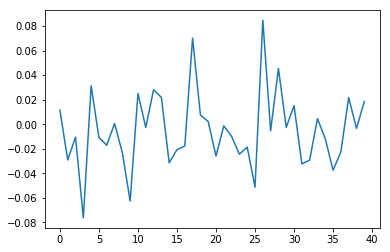

In [10]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

It seems that the error terms of our model are uncorrelated with each other, the autocorrelation between the errors of houses prices model is relatively low (ranging between -0.08 and 0.08).

## Assumption six: features shouldn't be correlated with the errors

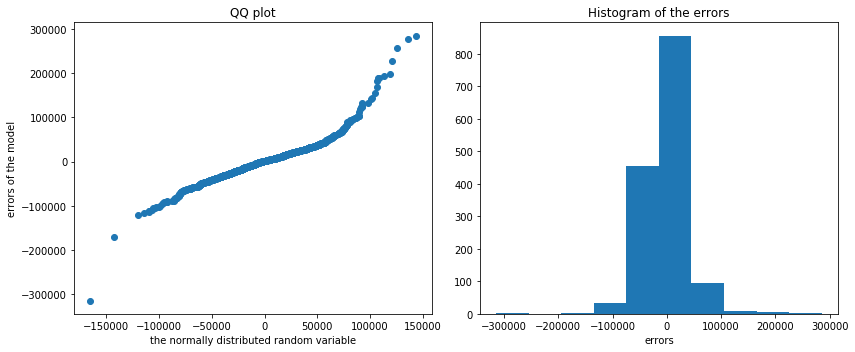

In [11]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [12]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 4540.524688257913 and p value is 0.0
Normality test statistics is 376.97097671325946 and p value is 1.3860933753516364e-82


Errors are not normally distributed exactly. But the QQ plot and the histogram imply that the distribution is not very far away from normal.

The p-values of both tests indicate that our errors are not normally distributed.